# Predicted conductance distirbutions

In [1]:
import os
import sys
import numpy as np
import json
import subprocess
import operator
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
mutant_names = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

In [3]:
path = 'data/mutants_docking_pdbnames_labelled.json'
with open(path, 'r') as fp:
    mutants_docking_pdbnames_labelled = json.load(fp)

HOLE failed for  cWza ['0112\n']
HOLE failed for  cWza ['0243\n']
HOLE failed for  cWza ['0800\n']


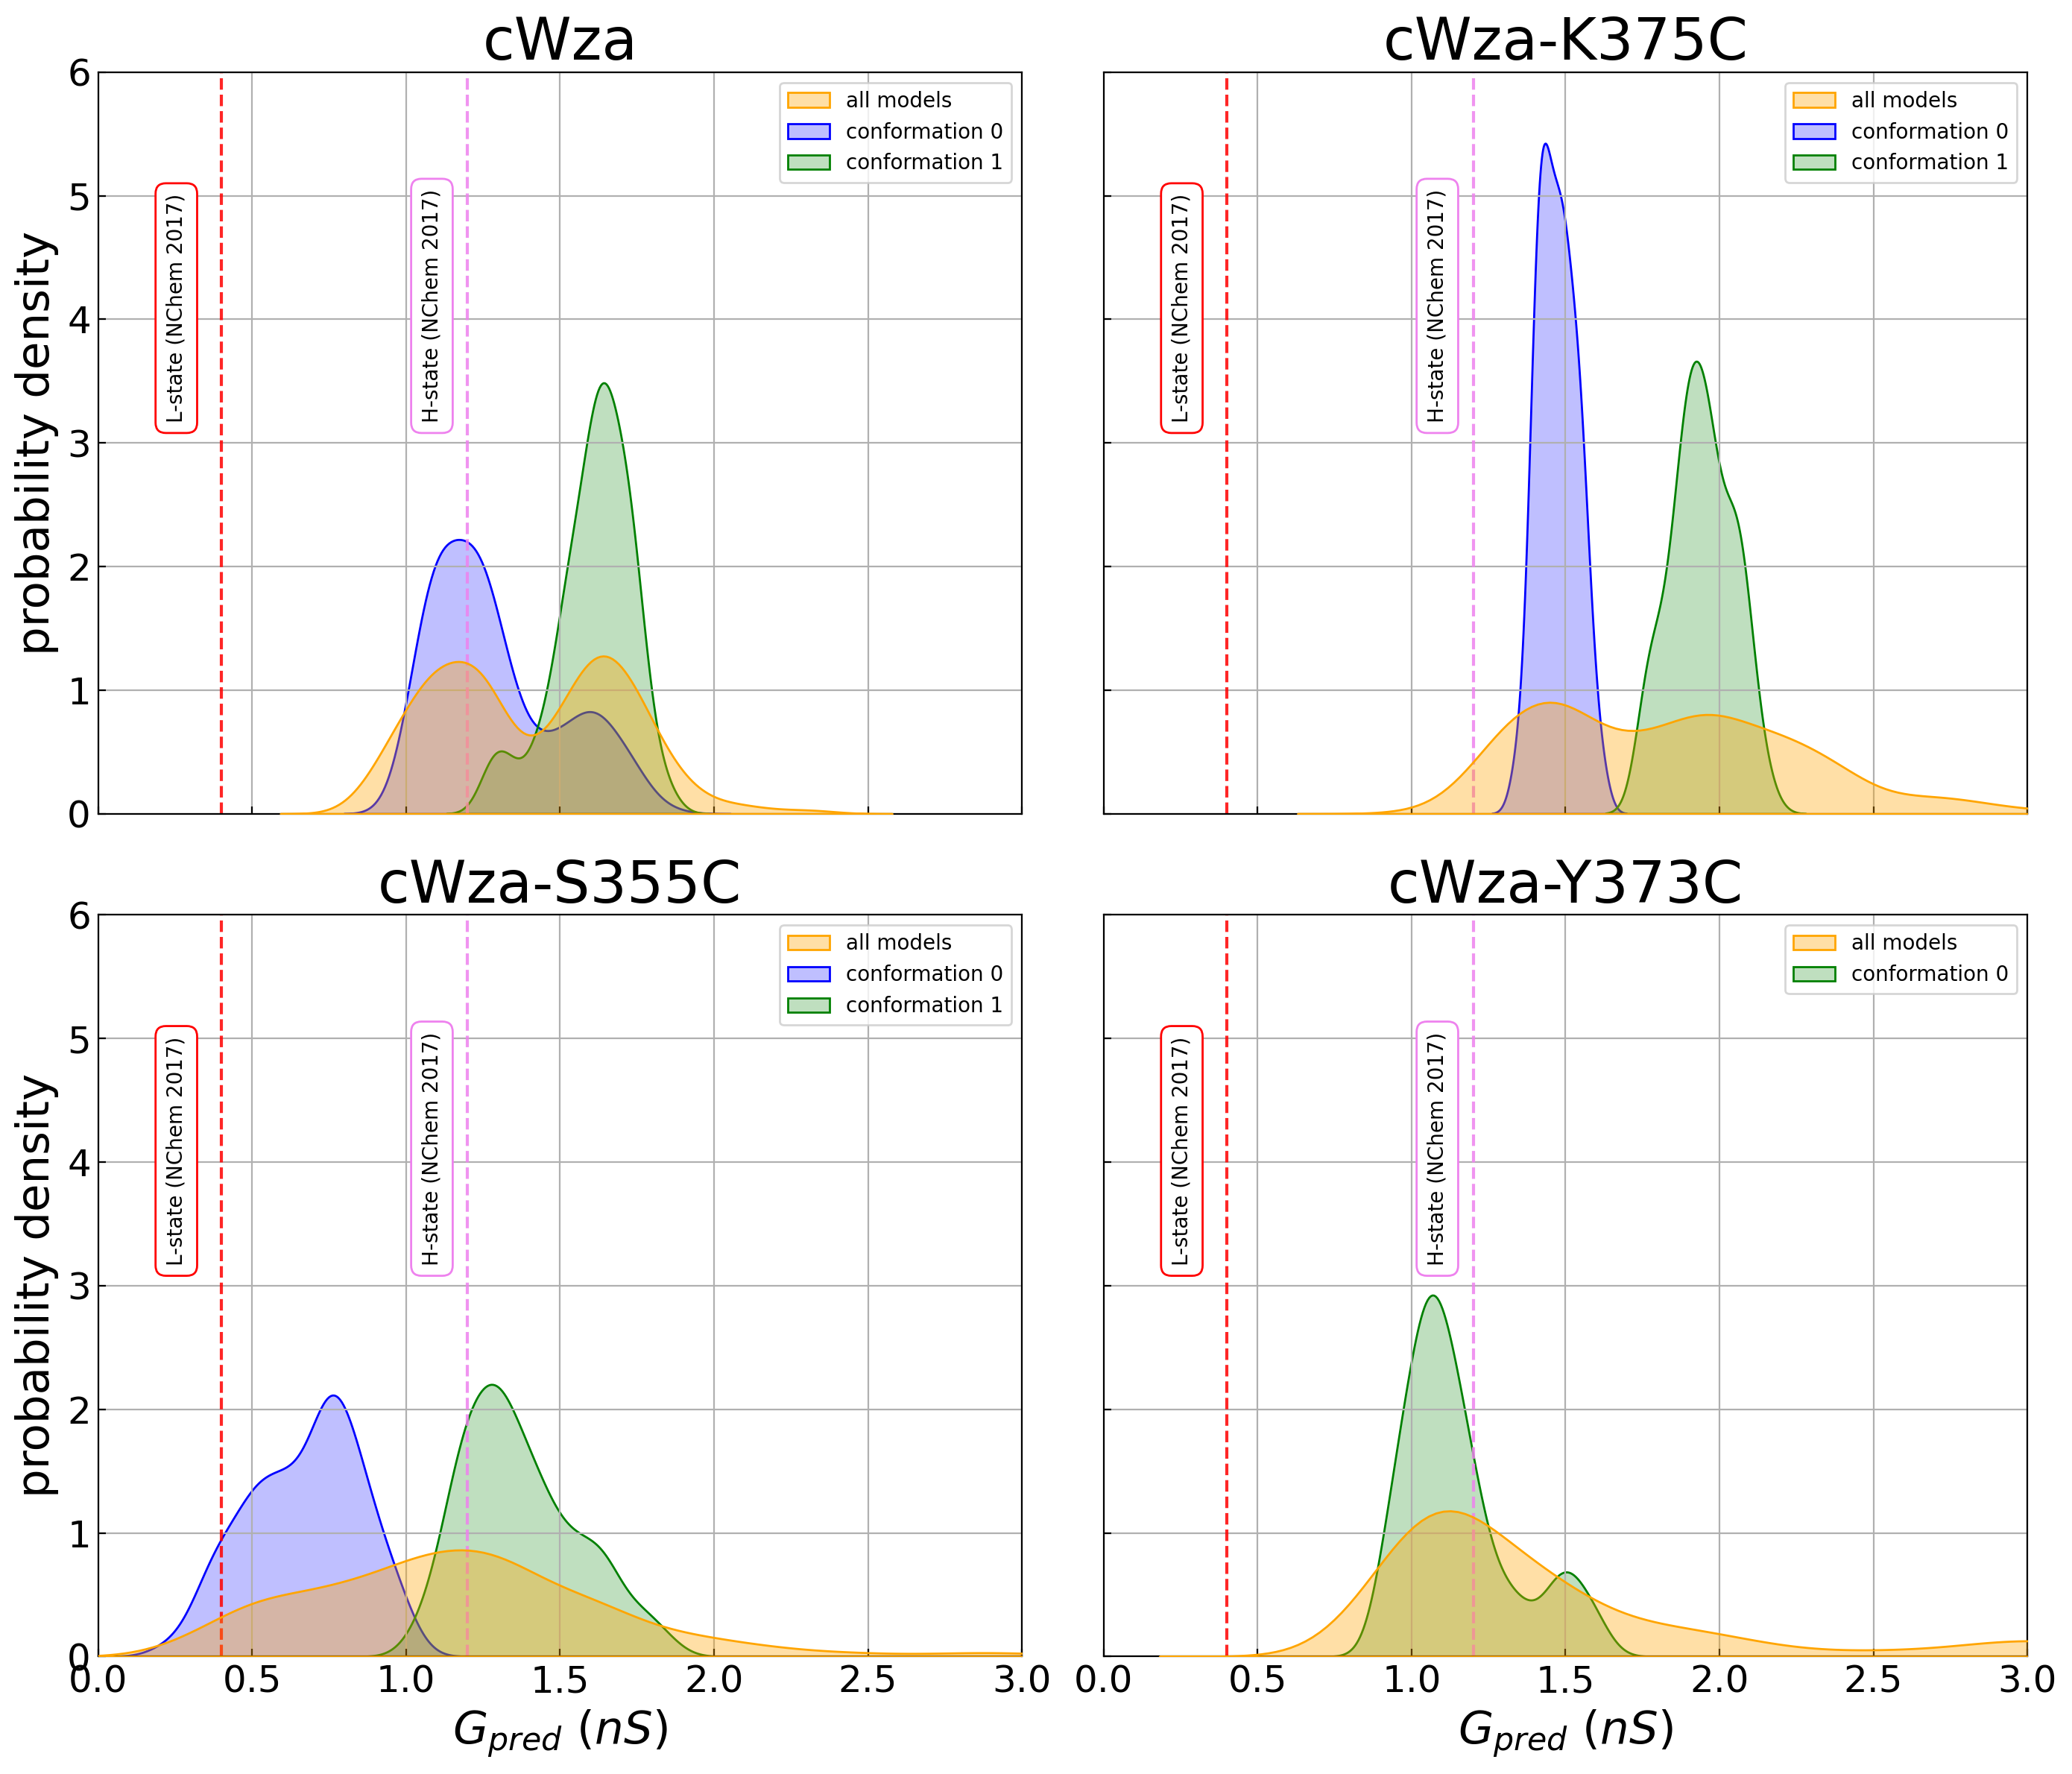

In [6]:
fig, ax = plt.subplots(2,2,figsize=(14,12),dpi=200, sharex=True,sharey=True)

Axes = {
    'cWza': ax[0][0],
    'cWza-K375C': ax[0][1],
    'cWza-S355C': ax[1][0],
    'cWza-Y373C': ax[1][1]
}

labels = {
    'cWza':("","probability density"),
    'cWza-K375C':("",""),
    'cWza-S355C':("$G_{pred}$ ($nS$)","probability density"),
    'cWza-Y373C':("$G_{pred}$ ($nS$)","")
}

Conformations = {
    'cWza': [0, 1],
    'cWza-K375C': [0, 1],
    'cWza-S355C': [0, 1],
    'cWza-Y373C': [0]    
}

Colors = {0:"blue", 1:'green'}

for mutant in mutant_names:
    ax = Axes[mutant]
    
    #filter HOLE data per mutant
    filename = 'data/'+mutant+'_hole_1-1000.raw_dat'
    lines = [l.split(' (TAG') for l in open(filename,'r').readlines()]
    Gpred_data = {}
    for l in lines:
        try:
            model_number, data_raw = l
            Gpred  = 0.001*float(data_raw.split("Gpred=")[-1].strip().split()[0])
            Gpred_data[model_number] = Gpred
        except:
            print("HOLE failed for ",mutant,l)
    
    dataset = list(Gpred_data.values())
    sns.kdeplot(dataset,shade=True,label='all models',color='orange',alpha=0.35,ax=ax,zorder=10)
    
    #filter data for PDBs within HPRs
    for g in Conformations[mutant]:
        model_numbers = [pdbname.split('_')[3] for pdbname in mutants_docking_pdbnames_labelled[mutant][str(g)]]
        
        models_labelled_Gpred  = []
        for x in model_numbers:
            try:
                models_labelled_Gpred.append(Gpred_data[x])
            except: KeyError
        
        if mutant == 'cWza-Y373C':
            c = 'green'
        else:
            c = Colors[g]
        dataset = models_labelled_Gpred
        sns.kdeplot(dataset,shade=True,label='conformation '+str(g),color=c,alpha=0.25,ax=ax,zorder=-10)

    # H-state cWza model (crystal structure)
    Gpred_cWza_Hstate = [1.2]
    ax.plot(2*Gpred_cWza_Hstate,(0,6),lw=1.5,linestyle='--',color='violet',alpha=0.85)
    ax.text(1.05,3.2,'H-state (NChem 2017)',rotation=90,fontsize=10,
            bbox=dict(facecolor='white', edgecolor='violet', boxstyle='round, pad=0.5'))
    
    #L-state cWza model (CCBuilder and BUDE optimised)
    Gpred_cWza_Lstate = [0.4]
    ax.plot(2*Gpred_cWza_Lstate,(0,6),lw=1.5,linestyle='--',color='red',alpha=0.85)
    ax.text(0.22,3.2,'L-state (NChem 2017)',rotation=90,fontsize=10,
            bbox=dict(facecolor='white', edgecolor='red', boxstyle='round, pad=0.5'))
    
    # customise plot
    ax.set_title(mutant, fontsize=28)
    ax.tick_params(axis='both',direction='in',labelsize=18)
    l1,l2 = labels[mutant]
    ax.set_xlabel(l1,fontsize=22)
    ax.set_ylabel(l2,fontsize=22)
    ax.legend(loc='best')
    ax.set_xlim(0,3)
    ax.set_ylim(0,6)
    ax.grid(True)

fig.tight_layout()
plt.show()

# RMSD sensitivity to differential conductance states

In [20]:
import os
import sys
import numpy as np
import json
import subprocess
import operator
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [21]:
mutant_names = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

In [22]:
path = 'data/mutants_docking_pdbnames_labelled.json'
with open(path, 'r') as fp:
    mutants_docking_pdbnames_labelled = json.load(fp)

In [23]:
models_conformation0 = mutants_docking_pdbnames_labelled['cWza']['0']
models_conformation1 = mutants_docking_pdbnames_labelled['cWza']['1']

Verify sets are mutually exclusive

In [24]:
set(models_conformation0).intersection( set(models_conformation1) )

set()

Parallel BB-RMSD calculation

In [28]:
import os
from pymol import cmd
from itertools import product

1. Prepare list of parameters

In [30]:
workdir = "data/docking_models/cWza_docked_models_data/"
join_paths = lambda file: os.path.join(workdir,file)

X0 = models_conformation0
X1 = models_conformation1
all_pdb_pairs = list(product(X0,X1))

pdb_pair_paths = [list(map(join_paths, pair)) for pair in all_pdb_pairs]

2. Define mapping function

In [31]:
def get_backbone_rmsd(pdb_pair_paths):
    # load PDBs
    pdb0 = cmd.load(pdb_pair_paths[0],'pdb0')
    pdb1 = cmd.load(pdb_pair_paths[1],'pdb1')
    
    # select backbone atoms
    pdb0_selection = 'pdb0 and bb.'
    pdb1_selection = 'pdb1 and bb.'
    
    # align structures and return BB-RMSD
    alignment_data = cmd.align(mobile=pdb0_selection,target=pdb1_selection)
    rmsd = alignment_data[0] # get rmsd after alignment

    return rmsd

3. Execute parallel calculation

In [72]:
from math import sqrt
from joblib import Parallel, delayed

n_cores = 4
f = get_backbone_rmsd
data_in = pdb_pair_paths

data_out = Parallel(n_jobs=n_cores)(delayed(f)(data_in[i]) for i in range(len(data_in)))

/data/dragon000/sanjuan/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


NOTE on performance: 44m 15s for 74120 PDB pairs

4. Save data in CSV format

In [83]:
import csv

output_file = 'data/docking_models/cWza_rmsd_data.csv'
with open(output_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["pdb_conformation0", "pdb_conformation1", "bb-rmsd"])
    [writer.writerow(list(all_pdb_pairs[i])+[data_out[i]]) for i in range(len(data_out))]

Read CSV data

In [86]:
import pandas as pd
df = pd.read_csv(output_file)
df

,pdb_conformation0,pdb_conformation1,bb-rmsd
0,refined1_0001_INPUT_0004_ignorechain.pdb,refined1_0001_INPUT_0010_ignorechain.pdb,0.913305
1,refined1_0001_INPUT_0004_ignorechain.pdb,refined1_0001_INPUT_0017_ignorechain.pdb,1.234555
2,refined1_0001_INPUT_0004_ignorechain.pdb,refined1_0001_INPUT_0014_ignorechain.pdb,0.947801
3,refined1_0001_INPUT_0004_ignorechain.pdb,refined1_0001_INPUT_0036_ignorechain.pdb,1.047288
4,refined1_0001_INPUT_0004_ignorechain.pdb,refined1_0001_INPUT_0040_ignorechain.pdb,1.196902
...,...,...,...
74115,refined1_0001_INPUT_0999_ignorechain.pdb,refined1_0001_INPUT_0951_ignorechain.pdb,0.918127
74116,refined1_0001_INPUT_0999_ignorechain.pdb,refined1_0001_INPUT_0959_ignorechain.pdb,0.961688
74117,refined1_0001_INPUT_0999_ignorechain.pdb,refined1_0001_INPUT_0963_ignorechain.pdb,0.961255
74118,refined1_0001_INPUT_0999_ignorechain.pdb,refined1_0001_INPUT_0976_ignorechain.pdb,0.960900


Heatmap

In [87]:
import seaborn as sns

In [ ]:
sns.heatmap(df, annot=False)

# APPENDIX

In [22]:
mutant = mutant_names[2]
filename = 'data/'+mutant+'_hole_1-1000.raw_dat'
lines = [l.split(' (TAG') for l in open(filename,'r').readlines()]

In [23]:
Gmacro_data = {}
Gpred_data = {}
for l in lines:
    try:
        model_number, data_raw = l
        
        Gmacro = 0.001*float(data_raw.split("Gmacro=")[-1].strip().split()[0])
        Gmacro_data[model_number] = Gmacro
        
        Gpred  = 0.001*float(data_raw.split("Gpred=")[-1].strip().split()[0])
        Gpred_data[model_number] = Gpred
    
    except:
        print("Error for model ",l)

<AxesSubplot:ylabel='Density'>

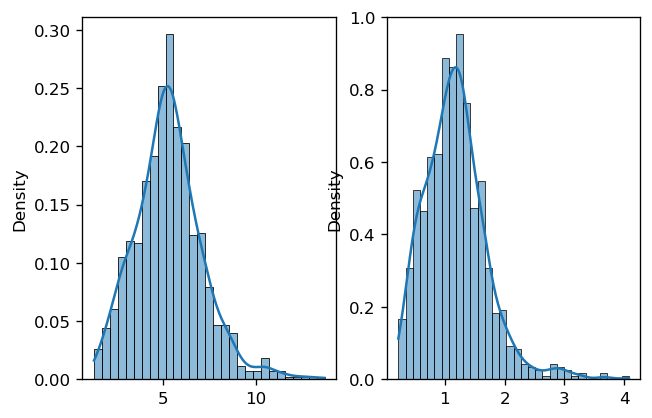

In [24]:
fig,ax = plt.subplots(1,2,dpi=120)

dataset = list(Gmacro_data.values())
sns.histplot(dataset,stat='density',kde=True,ax=ax[0])

dataset = list(Gpred_data.values())
sns.histplot(dataset,stat='density',kde=True,ax=ax[1])

In [29]:
model_numbers = [pdbname.split('_')[3] for pdbname in mutants_docking_pdbnames_labelled[mutant]['1']]

In [30]:
models_labelled_Gpred  = []
models_labelled_Gmacro = []
for x in model_numbers:
    try:
        models_labelled_Gpred.append(Gpred_data[x])
        models_labelled_Gmacro.append(Gmacro_data[x])
    except: KeyError

<AxesSubplot:ylabel='Density'>

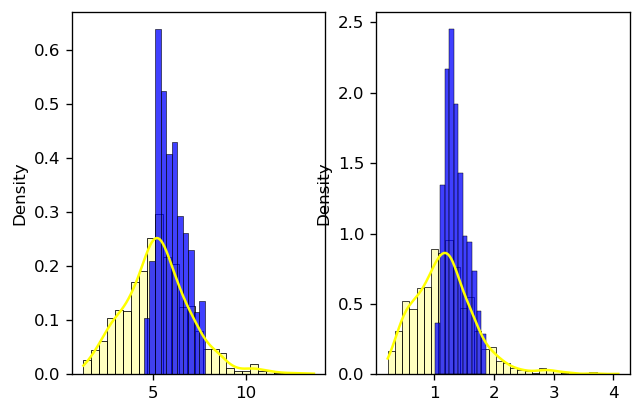

In [31]:
fig,ax = plt.subplots(1,2,dpi=120)

dataset = list(Gmacro_data.values())
sns.histplot(dataset,stat='density',kde=True,ax=ax[0], color='yellow',alpha=0.25)

dataset = models_labelled_Gmacro
sns.histplot(dataset,stat='density',ax=ax[0],color='blue')

dataset = list(Gpred_data.values())
sns.histplot(dataset,stat='density',kde=True,ax=ax[1], color='yellow',alpha=0.25)

dataset = models_labelled_Gpred
sns.histplot(dataset,stat='density',ax=ax[1],color='blue')

<AxesSubplot:ylabel='Density'>

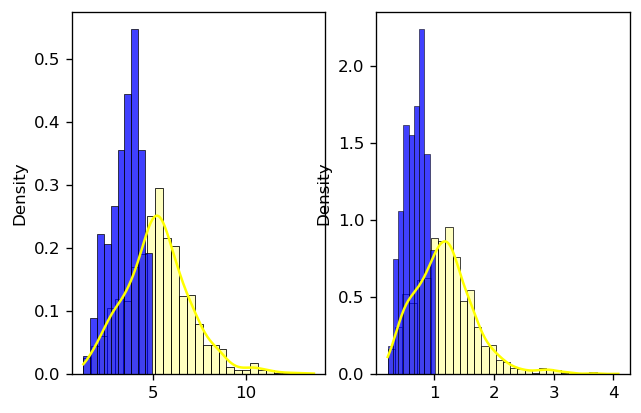

In [28]:
fig,ax = plt.subplots(1,2,dpi=120)

dataset = list(Gmacro_data.values())
sns.histplot(dataset,stat='density',kde=True,ax=ax[0], color='yellow',alpha=0.25)

dataset = models_labelled_Gmacro
sns.histplot(dataset,stat='density',ax=ax[0],color='blue')

dataset = list(Gpred_data.values())
sns.histplot(dataset,stat='density',kde=True,ax=ax[1], color='yellow',alpha=0.25)

dataset = models_labelled_Gpred
sns.histplot(dataset,stat='density',ax=ax[1],color='blue')

# TO-DO's

* Generate RMSD data for remiaining mutants using a script
* Visualise data as a heat map per mutant!